
<h1 id="Deriving-the-piano-keyboard-from-biological-principles-using-clustering-(Jupyter)">Deriving the piano keyboard from biological principles using clustering (Jupyter)<a class="anchor-link" href="#Deriving-the-piano-keyboard-from-biological-principles-using-clustering-(Jupyter)"></a></h1><p><em>Part of the <a href="https://omnisplore.wordpress.com/">omnisplore</a> blog</em>, taken from <a href="https://fiftysevendegreesofrad.github.io/JupyterNotes/piano.html">fiftysevendegreesofrad</a></p>
<h2 id="Introduction:-roughness-and-smoothness">Introduction: roughness and smoothness<a class="anchor-link" href="#Introduction:-roughness-and-smoothness"></a></h2><p>Once upon a time we were creatures in the wilderness and we evolved the ability to hear sounds. Now here's an interesting thing, if you hear a sound of frequency f and others of frequency 2f, 3f, etc then there's a good chance these sounds come from the same object, due to the physical principle of <a href="https://en.wikipedia.org/wiki/Resonance">resonance</a>. And so our perception of sound evolved to reflect this; we perceive any harmonic series of frequencies f, 2f, 3f etc as being <em>somehow related</em>. The effect is strongest for the 2f/f pair, but it's pretty strong for the 3f/2f pair as well. Talking of evolution, at some point we discovered that making decent music increases the odds of mating.  And so it came to pass that musical notation explicitly recognises the 2f/f relationship by giving all pairs of notes with frequencies in a 2/1 ratio - in music terminology, an octave apart - <em>the same name as one another</em>.</p>
<p>Another implication of all this is that there is a function <code>roughness(sounds)</code> that approximates how much we perceive a set of sounds as belonging together (smooth, or consonant) versus sounding different (dissonant, or rough). A github user called endolith already <a href="https://gist.github.com/endolith/3066664">implemented this in Python</a> as a function taking two lists: <code>roughness(frequencies, amplutides)</code>. It's not quite as neat as my first paragraph implies, because, um, I'm not a biologist but I gather human brains are fat that somehow thinks?  Also our ears have limited precision and we exploit the phenomenon of <a href="https://en.wikipedia.org/wiki/Beat_%28acoustics%29">beats</a> to help us detect differences in frequency. But I'm taking this as the biological basis for the rest of our adventure, at the end of which we will have deduced what a piano keyboard looks like.</p>
<p>Right. Let's start by testing <code>roughness</code> by computing how rough a 523Hz frequency sounds with every other frequency from 523-1046Hz:</p>


In [1]:
from sethares import dissmeasure as roughness

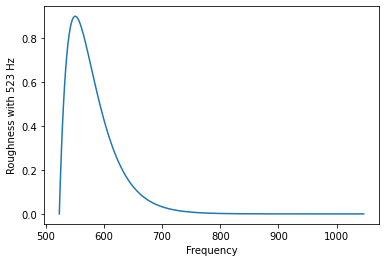

In [2]:

from __future__ import division
from numpy import exp, asarray, argsort, sort, sum, minimum
import numpy as np
import matplotlib.pyplot as plt

fmin = 261.63*2 # C above middle C
fmax = fmin*2

freqs=np.geomspace(fmin,fmax,200)
roughnesses = asarray([roughness([fmin,f],[1,1]) for f in freqs])
plt.plot(freqs,roughnesses)
plt.xlabel("Frequency")
plt.ylabel("Roughness with %d Hz"%fmin)
plt.show()




<p>But it's more complicated than that. A note played by a piano already contains multiple frequencies in a harmonic series, so when you play two together then you need to consider roughness of all the frequencies within each note clashing with one another.</p>


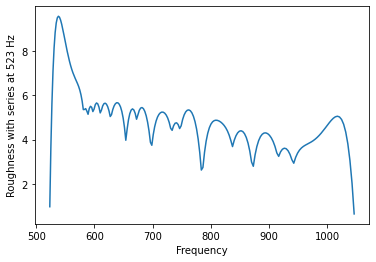

Mean roughness for all frequencies in interval f-2f: 4.957025538745176


In [3]:

def make_harmonic_series(f, n_harmonics, harmonic_decay):
    """
    Returns harmonic series as two arrays giving frequencies and amplitudes respectively
    """
    return float(f)*np.arange(1,n_harmonics+1) , harmonic_decay**np.arange(0,n_harmonics)

def roughness_two_series(f1,f2,n_harmonics=10, harmonic_decay=0.99):
    """
    Roughness of two harmonic series with fundamentals f1, f2
    Defaults to 10 harmonics with decay of 0.99 - I have no idea how well this matches a real piano
    """
    freq1,amp1 = make_harmonic_series(f1,n_harmonics,harmonic_decay)
    freq2,amp2 = make_harmonic_series(f2,n_harmonics,harmonic_decay)
    assert (amp1==amp2).all()
    f = np.append(freq1, freq2)
    a = np.append(amp1, amp2)
    return roughness(f,a)

roughnesses = asarray([roughness_two_series(fmin,f) for f in freqs])
plt.plot(freqs,roughnesses)
plt.xlabel("Frequency")
plt.ylabel("Roughness with series at %d Hz"%fmin)
plt.show()

print("Mean roughness for all frequencies in interval f-2f:", np.mean(roughnesses))




<p>Notice the big troughs in roughness at 1046Hz (corresponding to the 2f/1f relation, or 2/1 ratio discussed in the introduction) and 784Hz (corresponding to 3/2 ratio).</p>
<h2 id="Picking-some-notes-to-work-with">Picking some notes to work with<a class="anchor-link" href="#Picking-some-notes-to-work-with"></a></h2><p>Roughness and smoothness is all very well, but if you want to write some music, the conventional way to do it is to pick a subset of all possible frequencies to use for your <em>notes</em> and use these as the building blocks for your tune. Actually most musicians don't even do that, they just work with the notes others have picked already. This is unoriginal, perhaps, but convenient for working together.</p>
<p>Remember how the 2f/f relationship is strongest? Let's use this fact to simplify the task of picking notes, like this:</p>
<ol>
<li>pick a bunch of notes $n_1, n_2, n_3, $ etc beween f and 2f</li>
<li>add to our set of notes, all notes related to them by a factor of 2, i.e. $2n_1, 2n_2, 2n_3 ...$ and $4n_1, 4n_2, 4n_3, ...$ and $\frac{1}{2}n_1, \frac{1}{2}n_2, \frac{1}{2}n_3, ...$ and $\frac{1}{4}n_1, \frac{1}{4}n_2, \frac{1}{4}n_3, ...$ and so on, the only limiting factor being the range of human ability to perceive pitch.</li>
</ol>
<p>This is tantamount to saying we'll pick the notes that define a short section of piano keyboard, then copy and paste it all the way up and down the range of human hearing. But how do we choose the initial set of notes? I hope you'll agree these are some sensible criteria to guide us:</p>
<ol>
<li>the notes shouldn't sound too rough together</li>
<li>the notes should evenly span the range from f to 2f so when we want to play a sound of a given frequency, there's usually a suitable note close to it. ("Evenly" means on a evenly on a logarithmic scale, here, to match human pitch perception).</li>
</ol>
<p>Recall that notes related by a 2/1 ratio sound smooth together, and notes related by a 3/2 ratio sound nearly as smooth. The next thing we do is exploit a useful coincidence:</p>


In [4]:

print("3/2 to the power of 12 = ",(3/2)**12)
print("2/1 to the power of 7 = ",(2/1)**7)
print("These are within %.1f%% of one another!"%((3/2)**12/(2/1)**7*100-100))



3/2 to the power of 12 =  129.746337890625
2/1 to the power of 7 =  128.0
These are within 1.4% of one another!



<h3 id="Pythagorean-tuning">Pythagorean tuning<a class="anchor-link" href="#Pythagorean-tuning"></a></h3><p><a href="https://en.wikipedia.org/wiki/Pythagorean_tuning">Pythagorean tuning</a> is an algorithm which uses the coincidence above to derive a set of notes which sound reasonably good together. It does this by ensuring that that the ratio between any pair of notes chosen is approximately $(\frac{1}{2})^x (\frac{3}{2})^y$ and hence fairly smooth:</p>


In [5]:

# start with a single note 
pythag_freqs = [fmin]

while len(pythag_freqs)<12: # 12 is a magic number arising from the coincidence above
    # keep multiplying the most recent note by 3/2 to generate new notes
    next_freq = pythag_freqs[-1]*3/2
    # if a new note is higher than twice the original frequency (2f) then divide by two
    if next_freq > pythag_freqs[0]*2:
        next_freq /= 2
    pythag_freqs += [next_freq]
    
pythag_freqs.sort() # we'll want them in order later on




<p>Let's visualise those on a number line:</p>


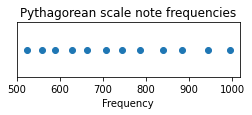

In [6]:

plt.figure(figsize=(4,1))
plt.scatter(pythag_freqs, np.zeros_like(pythag_freqs))
plt.yticks([])
plt.xlabel("Frequency")
plt.title("Pythagorean scale note frequencies")
plt.show()




<p>So there's a set of notes spanning from f1 to f2 that should sound relatively smooth together, fulfiling our criteria above.</p>
<p>Hang on, why do they span the whole range, rather than being bunched up to one side or other of the number line? Again it comes down to the coincidence $\frac{3}{2}^{12} \approx 2^7$. We keep multiplying our base frequency by $\frac{3}{2}$ and when we've done that 12 times we end up with a frequency higher than the original by a factor of roughly $2^7$. This is well outside the range shown, which is why we keep dividing all frequencies by 2 to keep them inside the correct range - and, in the case of the final $2^7$-ish frequency, this divides back down to become the same note we started with. Between whiles we have crossed the f-2f range a few times, filling it with notes which are roughly evenly spaced. In musical notation this is called the <a href="https://en.wikipedia.org/wiki/Circle_of_fifths">circle of fifths</a> (and my foggy memories of a discrete maths course tell me this result probably relates to coprimality, remainders and so on).</p>
<p>Remember our roughness function? Let's plot the roughness between any pair of these notes:</p>


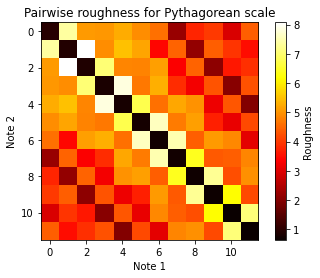

Mean roughness for Pythagorean scale: 4.347238031056978


In [7]:

pythag_roughnesses = [[roughness_two_series(f1,f2) for f2 in pythag_freqs] for f1 in pythag_freqs]

plt.imshow(pythag_roughnesses, cmap='hot', interpolation='nearest')
cb = plt.colorbar()
cb.set_label('Roughness')
plt.xlabel("Note 1")
plt.ylabel("Note 2")
plt.title("Pairwise roughness for Pythagorean scale")
plt.show()

print("Mean roughness for Pythagorean scale:", np.mean(pythag_roughnesses))




<p>We also computed that the mean roughness for any note pair is 4.35 - an improvement over the 4.96 for all possible frequencies in the interval, but let's take that with a pinch of salt, as it ignores roughness from notes outside the range shown.</p>
<h3 id="Equal-temperament-tuning">Equal temperament tuning<a class="anchor-link" href="#Equal-temperament-tuning"></a></h3><p>To summarize: Pythagorean tuning taught us that we can construct a set of 12 nice sounding notes related by ratios of the form $(\frac{1}{2})^x(\frac{3}{2})^y$, and when we do, these notes split the f-2f range into roughly equal intervals on a logarithmic scale.  Let's invert that logic, and propose that if we choose a different set of 12 notes that <em>exactly</em> splits the f-2f range into equal intervals on a log scale, they won't be too different to the Pythagorean set and hence won't sound too bad either.  This is the premise of <a href="https://en.wikipedia.org/wiki/Equal_temperament">equal temperament tuning</a> - which was first invented in China but is now the basis of most western music.</p>


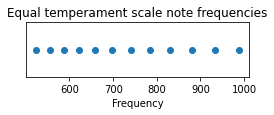

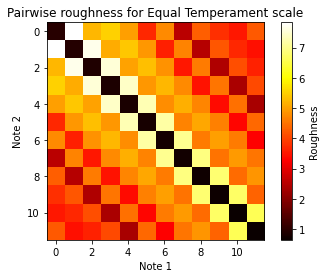

Mean roughness for equal temperament scale: 4.426610171677138


In [8]:

# 12 comes from the magic coincidence noted above
# but now we don't directly use the 3/2 ratio and just rely on the following to output
# notes that are roughtly related by some power of 3/2
equal_freqs = [fmin*(2**(1/12))**n for n in range(12)] 

plt.figure(figsize=(4,1))
plt.scatter(equal_freqs, np.zeros_like(equal_freqs))
plt.yticks([])
plt.xlabel("Frequency")
plt.title("Equal temperament scale note frequencies")
plt.show()

equal_roughnesses = [[roughness_two_series(f1,f2) for f2 in equal_freqs] for f1 in equal_freqs]

plt.imshow(equal_roughnesses, cmap='hot', interpolation='nearest')
cb = plt.colorbar()
cb.set_label('Roughness')
plt.xlabel("Note 1")
plt.ylabel("Note 2")
plt.title("Pairwise roughness for Equal Temperament scale")
plt.show()

print("Mean roughness for equal temperament scale:", np.mean(equal_roughnesses))




<p>Equal temperament has a mean roughness of 4.43, slightly rougher than Pythagorean (exercise for the reader: is this still the case if you consider notes above and below the range we're using?). Still, there's a good reason to use it. Notice how, unlike the pairwise roughnesses on the Pythagorean plot, every diagonal on the equal temperament plot has the approximately the same roughness along the length of the diagonal. Also, where diagonals do change in roughness, they do so smoothly. This means that whichever note you're currently playing, the relationship of that note to those above and below it on the scale is <em>always the same</em>. The practical implication is that it doesn't matter where on the scale you start from; you can play an equal temperament instrument in any key without having to retune it to minimize roughness for whatever you're currently playing.</p>
<h2 id="The-Piano">The Piano<a class="anchor-link" href="#The-Piano"></a></h2><p>Finally we can invent the piano! Suppose we wanted to divide our equal temperament scale into two clusters of notes, such that notes from each cluster tended to sound better with notes from the same cluster.</p>


In [9]:

from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=2)
ac.fit(1/asarray(equal_roughnesses))
equal_temp_clusters = ac.labels_
print("Equal Temperament cluster labels for each note (in order from low to high):",equal_temp_clusters)



Equal Temperament cluster labels for each note (in order from low to high): [0 1 0 1 0 0 1 0 1 0 1 0]



<p>Let's display those clusters another way:</p>


In [11]:

print("|".join([{0:"     ",1:"BLACK"}[x] for x in equal_temp_clusters]))
print("|".join([{0:"WHITE",1:"     "}[x] for x in equal_temp_clusters]))



     |BLACK|     |BLACK|     |     |BLACK|     |BLACK|     |BLACK|     
WHITE|     |WHITE|     |WHITE|WHITE|     |WHITE|     |WHITE|     |WHITE


<p>I'm hoping you can see the similarity:</p>
<p><img src="https://upload.wikimedia.org/wikipedia/commons/3/33/TAST1OKT.jpg" width="200"/></
<h2 id="Endnote">Endnote<a class="anchor-link" href="#Endnote"></a></h2><p>If you haven't already realised, I cheated slightly for the sake of simplicity. In particular, the analysis ignores clashes with notes outside the f-2f range, and also ignores the fact that our choice of starting note is arbitrary - so we're sort of lucky this worked so neatly. If you're feeling keen, I'm sure you could get the same result without ignoring these points.</p>


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cd7c04ef-2549-48b7-89c7-868da7720bfe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>